In [177]:
#standard imports 
import pandas as pd 
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import quandl
import functools
import os
import math
from datetime import datetime, timedelta
import requests
from itertools import combinations
import statsmodels 
import statsmodels.api as sm
from sklearn import metrics
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.datasets import make_regression
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import time

from datetime import datetime, timedelta


quandl.ApiConfig.api_key = HIDDEN
pd.set_option("max_columns", None) 
pd.set_option("max_rows", None)


# Exponentially Weighted Regression 
## By: Zach Mariani 

### Step 1: Obtain Daily Data 

For this assignment, we want to get the end of day data for the SPY and then 200+ other securities in the time range Jan 1, 2016 until Dec 31, 2020 and then convert it to daily returns. We will treat this as a regular time series. 

We will use the SPY and then all of the S&P500 equities (pulled from Wikipedia) as our 200+ other securities. 


In [185]:
#First, let's get the list of all the SP500 stocks from Wikipedia

url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find('table', {'class': 'wikitable'})
wiki_df = pd.read_html(str(table))
wiki_df = pd.DataFrame(wiki_df[0])
wiki_df.head()

#add SPY to the list of everything 
eq_lst = list(wiki_df['Symbol'].values)

#we then want to pick out only 250 of them in order to keep the script fast 
eq_lst = np.random.choice(np.asarray(eq_lst), 250, False)

#then add the SPY to the start of the data!
sp_lst = ['SPY']
sp_lst.extend(eq_lst)

Now that we have the list of equities that we're going to use, we are going to use Quandl to get their EOD data and store it all in a dictionary.

In [ ]:
#set the start and end dates 
start_date = '2016-01-01'
end_date = '2020-12-31'

#set up the full data dict
data = {}

#now loop through for each of tickers and get the EOD data and
#turn it into the daily returns - this process takes a couple of minutes 
#so it is best to just run it once and then be done with it...
for eq in sp_lst: 
    time_0 = time.time()
    try:
        EOD = quandl.get('EOD/' + eq, start_date=start_date, end_date=end_date, column_index = '11')
        EOD['Daily_Returns'] = EOD['Adj_Close'].pct_change(1)
        data[eq] = EOD
    except Exception as e: 
        print('Failed to get: ', eq)
    print('Secured Data for Eq:', eq, ' in ', time.time() - time_0, ' seconds ')

Now, we have gathered all of the relevant data, we will move onto building our exponentially weighted regressions. 

### Step 2: Exponentially Weighted Regressions

First, we will compute exponentially-weighted regression coefficients


In [486]:
def get_weights(X):
    '''
    The first thing we need to do is build a helper function which will generate the weights 
    that we need for the exponential function given a list X. The individual x_is represent 
    equity returns. 
    '''
    lst = []
    for x in range (0, len(X)):
            lst.append(math.exp(x))
    lst = np.array(lst)
    lst = lst / sum(lst)
    return lst

In [ ]:
lambdas = [0.1, 0.2, 0.5, 1.0, 2.0]
ws = [int(2/l) for l in lambdas]

EWRs = {}
weights_dict = get_weights_dict(lambdas)
#for every equity
for eq, eq_data in data.items():
    try: 
        time_0 = time.time()
        recordings = [[] for l in lambdas]
        this_eq_df = pd.DataFrame()

        #go thru every day 
        for day in eq_data['2016-02-01':].index:
            #get the SPY data 
            spy_window = data['SPY'][:day]
            spy_windows = [spy_window.iloc[-w:] for w in ws]

            #get this equity's data 
            temp_window = eq_data[:day]
            temps_windows = [temp_window.iloc[-w:] for w in ws]

            #save these as Ys and Xs
            Ys = [spy['Daily_Returns'] for spy in spy_windows]
            Xs = [temp['Daily_Returns'] for temp in temps_windows]
            
            #for each time w (window), go through and then get beta from OLS 
            for index_x in range(len(Xs)):
                X = Xs[index_x].dropna()
                Y = Ys[index_x].dropna()
                weights = get_weights(X)
                wls_model = sm.WLS(Y,X, weights=weights)
                beta = wls_model.fit().params['Daily_Returns']
                recordings[index_x].append(beta)

        #IF THE LEN OF LAMBDA CHANGES WE NEED TO CHANGE THIS SINCE IT'S 
        #HARD CODED 
        this_eq_df = pd.DataFrame({ws[0] : recordings[0], 
                                  ws[1] : recordings[1],
                                  ws[2] : recordings[2],
                                  ws[3] : recordings[3],
                                  ws[4] : recordings[4]}
                                  , index = eq_data['2016-02-01':].index
                                 )

        EWRs[eq] = this_eq_df
        
        #save them all to local disk so we don't have to run this again just in case!
        EWRs[eq].to_csv('/Users/zachmariani/Desktop/EWRs/' + eq + '.csv')
        
        print('Finished Equity: ', eq, ' in ', time.time() - time_0, ' seconds')
        
    except Exception as e: 
        print('Failed on Equity: ', eq, e)
        


Now that we have gathered our exponentially-weighted regression coefficients, we will use a similar strategy to get the boxcars.

In [ ]:
boxcars = {}
ws = [int(2/l) for l in lambdas]

#for every equity
for eq, eq_data in data.items():
    try: 
        time_0 = time.time()
        recordings = [[] for l in lambdas]
        this_eq_df = pd.DataFrame()

        #go thru every day 
        for day in eq_data['2016-02-01':].index:
            #get the SPY data 
            spy_window = data['SPY'][:day]
            spy_windows = [spy_window.iloc[-w:] for w in ws]

            #get this equity's data 
            temp_window = eq_data[:day]
            temps_windows = [temp_window.iloc[-w:] for w in ws]

            #save these are Ys and Xs
            Ys = [spy['Daily_Returns'] for spy in spy_windows]
            Xs = [temp['Daily_Returns'] for temp in temps_windows]
            
            #for each time w (window), go through and then get beta from OLS 
            for index_x in range(len(Xs)):
                X = Xs[index_x].dropna()
                Y = Ys[index_x].dropna()
                model = sm.OLS(Y, X).fit()
                beta = model.params['Daily_Returns']
                recordings[index_x].append(beta)

        #IF THE LEN OF LAMBDA CHANGES WE NEED TO CHANGE THIS SINCE IT'S 
        #HARD CODED 
        this_eq_df = pd.DataFrame({ws[0] : recordings[0], 
                                  ws[1] : recordings[1],
                                  ws[2] : recordings[2],
                                  ws[3] : recordings[3],
                                  ws[4] : recordings[4]}
                                  , index = eq_data['2016-02-01':].index
                                 )

        boxcars[eq] = this_eq_df
        
        #now we just save this to local incase we have to reload it later to avoid 
        #having to re-run the code 
        path = '/Users/zachmariani/Desktop/boxcars/boxcars' + key + '.csv'
        value.to_csv(path)
        print('Finished Equity: ', eq, ' in ', time.time() - time_0, ' seconds')
        
    except Exception as e: 
        print('Failed on Equity: ', eq, e)

Now, finally that we have both of our boxcar and exponentially weighted regression coefficients, we are going to generate the "correct" regression coefficients. We do this by taking the forward 5-trading day boxcar windows. 

In [ ]:
correct = pd.DataFrame()
#for every equity

for eq, eq_data in data.items():
    #this try except loop mostly just catches when the X and Y variables don't have the same 
    #dimensions, this happens when an eq has fewer days of data available than SPY 
    #if this is the case, we just throw them out, since we have ~250 tickers we end up with 
    #well over 200+ 
    try: 
        #we need to save as a string instead of the default np.str_ object
        #which would later throw an error 
        eq = str(eq)
        time_0 = time.time()
        recordings = []
        this_eq_df = pd.DataFrame()

        #go thru every day 
        for day in eq_data['2016-02-01':].index:
            i_index = eq_data.index.get_loc(day)
            i_forward = i_index + 5 

            #get the SPY data for the next five days
            Y = data['SPY'][i_index:i_forward]['Daily_Returns'].dropna()

            #get this equity's data for the next five days
            X = eq_data[i_index:i_forward]['Daily_Returns'].dropna()

            #run a simple OLS (no weighting)
            model = sm.OLS(Y, X).fit()
            beta = model.params['Daily_Returns']
            recordings.append(beta)

        this_eq_df = pd.DataFrame({eq : recordings}
                                  ,index = eq_data['2016-02-01':].index
                                 )

        correct[eq] = this_eq_df[eq]

        #now we just save this to local incase we have to reload it later to avoid 
        #having to re-run the code, we just save everything in one csv now since each 
        #individual eq just has one column 
        path = '/Users/zachmariani/Desktop/correct.csv'
        correct.to_csv(path)

        print('Finished Equity: ', eq, ' in ', time.time() - time_0, ' seconds')
        
    except Exception as e: 
        print('Failed on Equity: ', eq, e)

Our final step now is to assemble the data in one large DataFrame so that it is easy to read and interpret.

In [311]:
'''
Check that everything has the same # of equities and that everything looks to be in order. 
'''
print('We have: ', len(boxcars.keys()), 'equities in Boxcar')
print('We have: ', len(EWRs.keys()), 'equities in EWRs')
print('We have: ',len(correct.columns), 'equities in Correct')

We have:  241 equities in Boxcar
We have:  241 equities in EWRs
We have:  241 equities in Correct


In [ ]:
final_df = pd.DataFrame(index = correct['SPY'].index)
for eq in correct.columns: 
    time_0 = time.time()
    final_df[(eq, 'Correct', 'C')] = correct[eq]
    
    boxcar_eq = boxcars[eq]
    for column in boxcar_eq: 
        final_df[(eq, 'Boxcar', column)] = boxcar_eq[column]
    
    EWRs_eq = EWRs[eq]
    for column in EWRs_eq: 
        final_df[(eq, 'EWR', column)] = EWRs_eq[column]
    
    final_df.to_csv('/Users/zachmariani/Desktop/final.csv')
    print('Finished Eq: ', eq, 'time ', time.time() - time_0)
    
final_df = final_df.transpose()
final_df.index = pd.MultiIndex.from_tuples(final_df.index)
final_df = final_df.transpose()

In [316]:
final_df.head()

SPY                                                      \
           Correct Boxcar                      EWR                       
                 C     20   10    4    2    1   20   10    4    2    1   
Date                                                                     
2016-02-01     1.0    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
2016-02-02     1.0    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
2016-02-03     1.0    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
2016-02-04     1.0    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
2016-02-05     1.0    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

                 DHR                                                    \
             Correct    Boxcar                                           
                   C        20        10         4         2         1   
Date                                                                     
2016-02-01  0.713742  1.023927  1.054596  0.919703  0.866402  0.045382   
2016-02-02  0.812879  1.019055  1.048850  0.907778  0.829082  0.974330   
2016-02-03  0.605066  1.014457  1.010421  0.892750  0.940182  0.754916   
2016-02-04  0.593089  0.943256  0.911303  0.551217  0.217795  0.094583   
2016-02-05  0.782955  0.963137  0.885867  0.758536  0.622469  1.168004   

                                                                  MNST  \
                 EWR                                           Correct   
                  20        10         4         2         1         C   
Date                                                                     
2016-02-01  0.773842  0.773824  0.769093  0.759706  0.045382  0.178783   
2016-02-02  0.923951  0.923952  0.921678  0.915036  0.974330  0.226536   
2016-02-03  0.877838  0.877829  0.875506  0.901091  0.754916  0.198446   
2016-02-04  0.279636  0.279636  0.255412  0.145972  0.094583  0.201894   
2016-02-05  0.872756  0.872745  0.874196  0.872323  1.168004  0.256429   

                                                                        \
              Boxcar                                               EWR   
                  20        10         4         2         1        20   
Date                                                                     
2016-02-01  0.341491  0.235042 -0.511796 -0.692470 -0.020332 -0.338636   
2016-02-02  0.362325  0.290994 -0.362266  0.406535  1.890675  0.478217   
2016-02-03  0.354967  0.243578 -0.371668  0.705542 -0.680027 -0.054603   
2016-02-04  0.258299  0.158907  0.013478 -0.053977 -0.032753 -0.033330   
2016-02-05  0.276341  0.137849  0.195263  0.171685  0.517375  0.302686   

                                                         HLT            \
                                                     Correct    Boxcar   
                  10         4         2         1         C        20   
Date                                                                     
2016-02-01 -0.338667 -0.356466 -0.363446 -0.020332  0.340726  0.285562   
2016-02-02  0.478259  0.477555  0.818178  1.890675  0.367902  0.297752   
2016-02-03 -0.054748 -0.058414  0.093103 -0.680027  0.292153  0.298978   
2016-02-04 -0.033332 -0.030480 -0.040726 -0.032753  0.215167  0.287693   
2016-02-05  0.302681  0.304952  0.306401  0.517375  0.456465  0.278454   

                                                                        \
                                                         EWR             
                  10         4         2         1        20        10   
Date                                                                     
2016-02-01  0.183928  0.248396  0.629307 -0.042908  0.358852  0.358837   
2016-02-02  0.226372  0.298200  0.451531  0.475997  0.453446  0.453453   
2016-02-03  0.264846  0.556938  0.488184  0.796867  0.480834  0.480881   
2016-02-04  0.248363  0.254541  0.067222  0.040151  0.104548  0.104550   
2016-02-05  0.280368  0.347984  0.255512  0.703300  0.420376  0.420387   

             

After taking a look at the final_df.head(), we see that everything is in order and good to go. We now begin part 3.

### Step 3: Analysis

The first thing to do will be to get the mean squared errors. 

In [317]:
mses_dict = {}

for ticker in final_df.columns.levels[0]:
    ticker_specific = final_df[ticker]
    ticker_correct = ticker_specific['Correct']['C']
    mse_lst = []
    for col in ticker_specific.columns:
        r_type, l = col 
        if r_type != 'Correct':
            mse_lst.append(metrics.mean_squared_error(ticker_correct, ticker_specific[col]))
    mses_dict[ticker] = mse_lst

mse_df = pd.DataFrame(mses_dict, index = final_df['SPY'].columns[1:])
            

In [320]:
mse_df.head(10)

A         AAP        ACN        ADI           ADM  \
Boxcar 20   0.093765    0.127776   0.109746   0.062846  1.175307e-01   
       10   0.096134    0.136207   0.118875   0.071119  1.259900e-01   
       4    0.149484    0.186073   0.150408   0.091821  1.806354e-01   
       2    1.292548    0.985149   4.894168   0.986631  9.698312e-01   
       1   25.641966  309.486934  27.704982  28.488974  1.360254e+23   
EWR    20   0.160217    0.243265   0.161553   0.107948  2.296009e-01   
       10   0.160360    0.243578   0.161624   0.107984  2.297326e-01   
       4    0.195540    0.295322   0.181128   0.121083  2.827416e-01   
       2    2.116397    1.055582   5.512784   0.992823  1.037628e+00   
       1   25.641966  309.486934  27.704982  28.488974  1.360254e+23   

                ADSK        AEP        AFL        AIG        AIZ        AJG  \
Boxcar 20   0.047505   0.244809   0.177968   0.129183   0.150288   0.171803   
       10   0.050321   0.273862   0.184038   0.142184   0.161491   0.166113   
       4    0.075095   0.458281   0.269736   0.189219   0.259551   0.255818   
       2    0.437643   1.914692   1.770992   0.552474   1.388126   0.959896   
       1   60.818171  43.810385  15.345977  20.864710  47.585538  24.833666   
EWR    20   0.078727   0.495297   0.274137   0.183697   0.264137   0.279533   
       10   0.078772   0.495443   0.274274   0.183802   0.264267   0.279690   
       4    0.091004   0.567801   0.336651   0.218550   0.688347   0.326307   
       2    0.337428   2.144608   2.569563   0.647720   2.001365   0.984856   
       1   60.818171  43.810385  15.345977  20.864710  47.585538  24.833666   

                 AKAM        ALK       ALLE       ALXN       AMD        AME  \
Boxcar 20    0.102888   0.067146   0.101286   5.141989  0.026832   0.107533   
       10    0.105633   0.070003   0.096705   5.098138  0.027912   0.103486   
       4     0.151583   0.107218   0.133130   5.107439  0.038516   0.142817   
       2     0.722732   0.447893   0.529862   5.398556  0.354426   0.605256   
       1   100.969268  15.568356  25.590377  31.784834  6.880190  20.008479   
EWR    20    0.152051   0.119819   0.150418   5.142239  0.043540   0.150741   
       10    0.152240   0.119903   0.150455   5.141584  0.043661   0.150863   
       4     0.181288   0.154337   0.175061   5.156984  0.053305   0.173741   
       2     0.744537   0.470829   0.516275   5.395465  0.361592   1.088187   
       1   100.969268  15.568356  25.590377  31.784834  6.880190  20.008479   

                 AMP        AMT        AON        AOS        APH        AVB  \
Boxcar 20   0.047328   0.156673   0.186661   0.109357   0.108825   0.178374   
       10   0.049425   0.177409   0.190209   0.108454   0.108662   0.202807   
       4    0.077230   0.282720   0.263958   0.145538   0.170442   0.322776   
       2    0.274512   1.662720   0.837077   0.642137   0.961658  10.330052   
       1   39.255976  76.145847  26.121960  15.797038  25.260657  55.028994   
EWR    20   0.083141   0.316131   0.283129   0.157431   0.192583   0.350211   
       10   0.083200   0.316339   0.283270   0.157524   0.192704   0.350330   
       4    0.111445   0.373324   0.350162   0.183199   0.233500   0.456980   
       2    0.318294   1.720073   0.932046   0.697517   1.094583   9.951586   
       1   39.255976  76.145847  26.121960  15.797038  25.260657  55.028994   

                AVGO        AXP        BAX       BEN        BIIB        BIO  \
Boxcar 20   0.053630   0.107860   0.163431  0.063047    0.086492   0.117407   
       10   0.060598   0.110682   0.168989  0.062567    0.084401   0.116636   
       4    0.081206   0.140860   0.267231  0.089932    0.122125   0.170035   
       2    0.965322   0.533756   1.127540  0.248496    0.664388   0.825731   
       1   64.270435  28.121960  29.430675  5.653164  358.488124  68.019117   
EWR    20   0.085062   0.147098   0.273090  0.096326    0.139707   0.189487   
       10   0.085090   0.147171   0.273491  0.096370    0.13990

and now that we have a df of the Mean Squared Errors, we are going to make a DataFrame of just the raw errors which will be helpful later for some more advanced analysis. 

In [ ]:
#we want to build a timeseries for each of the average raw errors across all equities 
raw_errors_dict = {}

n = 0

#for each ticker 
for ticker in final_df.columns.levels[0]:
    n += 1
    ticker_specific = final_df[ticker]
    ticker_correct = ticker_specific['Correct']['C']
    for r_type, l in ticker_specific.columns: 
        if r_type != 'Correct':
            #we find the difference between each least squares estimation and the correct one
            temp = ticker_specific[(r_type, l)] - ticker_correct
            
            #then add them all up sorted by each one of the 10 least squares estimations
            #Boxcar and EWR times 5 different lambdas 
            try: 
                raw_errors_dict[(r_type, l)] += temp
            except Exception as e: 
                print(e)
                raw_errors_dict[(r_type, l)] = temp

                #then we go through and divide by the number of equities to get the average 
for key, value in raw_errors_dict.items(): 
    raw_errors_dict[key] = value / n
            

Now that we have both the MSEs for each equity and lambda as well as the raw_errors_dict. We will begin our analysis. First, let's take a look at broadly how each one of our ten regressions performed as measured by their MSEs.

In [354]:
mse_stats = pd.DataFrame()

mse_stats['Mean'] = mse_df.mean(axis = 1)
mse_stats['Std'] = mse_df.std(axis = 1)
mse_stats['Median'] = mse_df.median(axis = 1)
mse_stats['Min'] = mse_df.min(axis = 1)
mse_stats['Max'] = mse_df.max(axis = 1)

In [538]:
#take a quick look 
mse_stats

Mean           Std     Median           Min           Max
Boxcar 20  1.510131e-01  3.550814e-01   0.107458  1.055360e-31  5.141989e+00
       10  1.553339e-01  3.534060e-01   0.107720  1.084187e-31  5.098138e+00
       4   2.166361e-01  3.615480e-01   0.151922  1.007647e-31  5.107439e+00
       2   1.289945e+00  2.840598e+00   0.818169  9.744460e-32  4.194192e+01
       1   4.053648e+22  3.889217e+23  28.121960  3.225806e-03  5.614871e+24
EWR    20  2.328257e-01  3.658136e-01   0.164600  1.152576e-31  5.142239e+00
       10  2.329648e-01  3.657991e-01   0.164681  1.024843e-31  5.141584e+00
       4   2.763592e-01  3.761776e-01   0.200751  1.068680e-31  5.156984e+00
       2   1.413073e+00  2.904906e+00   0.901147  9.773287e-32  4.227759e+01
       1   4.053648e+22  3.889217e+23  28.121960  3.225806e-03  5.614871e+24

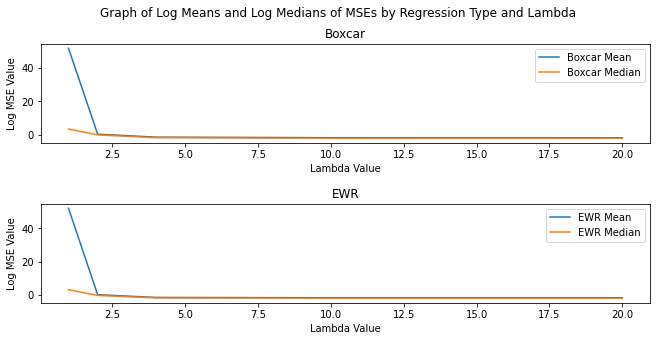

In [456]:
fig, ax = plt.subplots(2, figsize = (10, 5))
fig.tight_layout(pad = 4.0)
ax[0].plot(mse_stats['Mean']['Boxcar'].index, np.log(mse_stats['Mean']['Boxcar']), label = 'Boxcar Mean')
ax[0].plot(mse_stats['Median']['Boxcar'].index, np.log(mse_stats['Median']['Boxcar']), label = 'Boxcar Median')
# index = np.array(mse_stats['Std']['Boxcar'].index, dtype = int)
ax[0].set_title('Boxcar')
ax[0].legend()
# top = np.array(mse_stats['Std']['Boxcar'] + mse_stats['Mean']['Boxcar'], dtype = float)
# bottom = np.array(mse_stats['Std']['Boxcar'] - mse_stats['Mean']['Boxcar'], dtype = float)

# ax[0].fill_between(index, top, bottom, alpha = 0.1)
ax[0].set_xlabel('Lambda Value')
ax[0].set_ylabel('Log MSE Value')

ax[1].plot(mse_stats['Mean']['EWR'].index, np.log(mse_stats['Mean']['EWR']), label = 'EWR Mean')
ax[1].plot(mse_stats['Median']['EWR'].index, np.log(mse_stats['Median']['EWR']), label = 'EWR Median')
ax[1].set_xlabel('Lambda Value')
ax[1].set_ylabel('Log MSE Value')
ax[1].set_title('EWR')

plt.legend()
fig.suptitle('Graph of Log Means and Log Medians of MSEs by Regression Type and Lambda');


Given that the data is difficult to interpret when we include lambda = 1, we will exclude it and generate a similar graph. This one includes blue bands around the means to represent the stds. We clearly see that the EWR is consistently worse than the Boxcar and that both do moderately better at longer time spans ie. lambda at 10 and 20 over 2, and 4. This contradicts the economic intuition. We hypothesized that it makes sense that data today should be worth more than data from yesterday and data from the day before yesterday even less than that. It follows that since the present should be the best predictor of the future (compared to the distant past) a regression which weights things closer would be better than one which weighs things far away. As we can see from the graphs of their MSEs, we had exactly the opposite happen. The boxcar was better at predicting the "correct" future trends. This might be because of the fact that the correct future trends were determined by a boxcar or the shape of the curve we used to discount past weightings. If it were the case that we gave too much or too little of a weight on any given data point, we might have messed up any better predictive powers of the EWRs. It might be the case that in the equity markets we have that many of the very large moves up or down are one offs and unlikely to predict future moves. It would then be the case that since more recent data is weighted more, it would throw off the EWR regression in a way that the Boxcar regression would be immune to. This might be made worse by the fact that correct regression is the five day future boxcar in which any giant flare ups might have calmed down over the next five days (maybe they only last one or two days max). 

It is very interesting that the worst lambda is 1. The economic intuition would imply that recent data would be the best and there is no more recent data than the most recent day. However, we see that it is a *horrible* predictor. This might be because one off events are very heavily weighted and mislead the predictions. 

We also have that the median is lower than the mean in both cases which makes a lot of sense given the fact that being closer to 0 represents having larger MSEs and further from 0 represents smaller MSEs. There must have been a couple of outlier events dragging up the mean MSEs in both cases. 

We can also see from the std bands that the STD of the Boxcar goes much wider than that of the EWR which is an interesting find as well. It is unclear to me why this might be the case and could be interesting to explore more in the future potentially. 

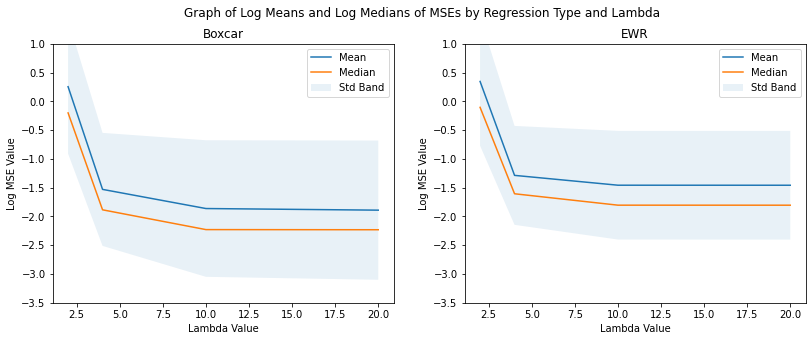

In [536]:
ex_1 = mse_stats.drop(('Boxcar', 1)).drop(('EWR', 1))

fig, ax = plt.subplots(1, 2, figsize = (12, 5))
fig.tight_layout(pad = 4.0)

### Boxcar Plot
ax[0].plot(ex_1['Mean']['Boxcar'].index, np.log(ex_1['Mean']['Boxcar']), label = 'Mean')
ax[0].plot(ex_1['Median']['Boxcar'].index, np.log(ex_1['Median']['Boxcar']), label = 'Median')

index = np.array(ex_1['Std']['Boxcar'].index, dtype = int)
top = ex_1['Mean']['Boxcar'] + ex_1['Std']['Boxcar']
top = np.log(top)
bottom = np.log(ex_1['Mean']['Boxcar']) - np.abs(np.log(ex_1['Mean']['Boxcar']) - top)
ax[0].fill_between(index, bottom, top, alpha = 0.1, label = 'Std Band')

ax[0].set_title('Boxcar')
ax[0].legend()

ax[0].set_xlabel('Lambda Value')
ax[0].set_ylabel('Log MSE Value')
ax[0].set_ylim(-3.5, 1)

### EWR plot 

ax[1].plot(ex_1['Mean']['EWR'].index, np.log(ex_1['Mean']['EWR']), label = 'Mean')
ax[1].plot(ex_1['Median']['EWR'].index, np.log(ex_1['Median']['EWR']), label = 'Median')
ax[1].set_xlabel('Lambda Value')
ax[1].set_ylabel('Log MSE Value')
ax[1].set_title('EWR')
ax[1].set_ylim(-3.5, 1)

index = np.array(ex_1['Std']['EWR'].index, dtype = int)
top = ex_1['Mean']['EWR'] + ex_1['Std']['EWR']
top = np.log(top)
bottom = np.log(ex_1['Mean']['EWR']) - np.abs(np.log(ex_1['Mean']['EWR']) - top)
ax[1].fill_between(index, bottom, top, alpha = 0.1, label = 'Std Band')



plt.legend()
fig.suptitle('Graph of Log Means and Log Medians of MSEs by Regression Type and Lambda');



We can see below that the differences in their printed minimums were very, very low (this made it difficult to represent graphically) and that like the other metrics (for the most part we see that as lambda gets shorter the MSE gets larger). However, notably, we find that for the EWR the lambda at 10 has a lower MSE than for the lambda at 20. This is an interesting find and could potentially tell us something about the lambdas we are choosing. 

In [375]:
print('The minimum values for the EWRs: ')
mse_stats['Min']['EWR']

The minimum values for the EWRs: 


20    1.152576e-31
10    1.024843e-31
4     1.068680e-31
2     9.773287e-32
1     3.225806e-03
Name: Min, dtype: float64

In [374]:
print('The minimum values for the Boxcars: ')
mse_stats['Min']['Boxcar']

The minimum values for the Boxcars: 


20    1.055360e-31
10    1.084187e-31
4     1.007647e-31
2     9.744460e-32
1     3.225806e-03
Name: Min, dtype: float64

For maximums, we see that the Boxcar and the EWR have almost exactly the same MSE maximums. There is slight variation, but not by much. 

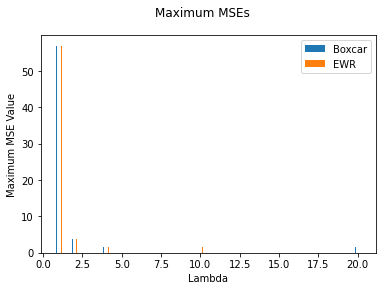

In [440]:
fig, ax = plt.subplots()
# index = ['20', '10', '4', '2', '1']
plt.bar(mse_stats['Max']['Boxcar'].index-0.15, np.log(mse_stats['Max']['Boxcar']), label = 'Boxcar', width =0.05)
plt.bar(mse_stats['Max']['EWR'].index+0.15, np.log(mse_stats['Max']['EWR']), label = 'EWR', width = 0.05)
fig.suptitle("Maximum MSEs")
plt.xlabel('Lambda')
plt.ylabel("Maximum MSE Value")
plt.legend();

So far, we've found that the Boxcar is a better predictor than the MSE (at least for this dataset with these values for Lambda) and we will now look at a timeseries to see if there are any more insights to find.

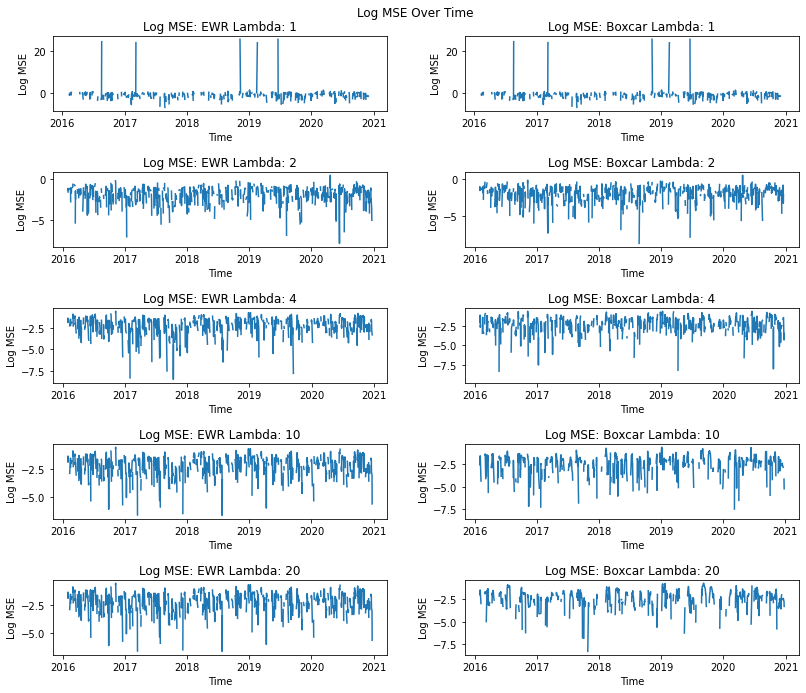

In [570]:
y_dict = {1:0, 
         2:1, 
         4: 2, 
          10: 3, 
          20:4
         }
fig, ax = plt.subplots(5, 2, figsize = (12, 10))
fig.tight_layout(pad = 4.0)
for key, value in raw_errors_dict.items():
    r_type, l = key 
    if r_type == "Boxcar":
        x_cord = 1
    if r_type == 'EWR':
        x_cord = 0
    y_cord = y_dict[l]
    ax[y_cord, x_cord].plot(np.log(value))
    ax[y_cord, x_cord].set_xlabel('Time')
    ax[y_cord, x_cord].set_ylabel('Log MSE')
    ax[y_cord, x_cord].set_title('Log MSE: ' + str(r_type) + ' Lambda: '+ str(l))
    
fig.suptitle("Log MSE Over Time");

We can clearly see that the lambdas that are not 1 do much better than when lambda is 1. It is a bit difficult to tell which one performed better at each period in time so we create another similar graph below. 

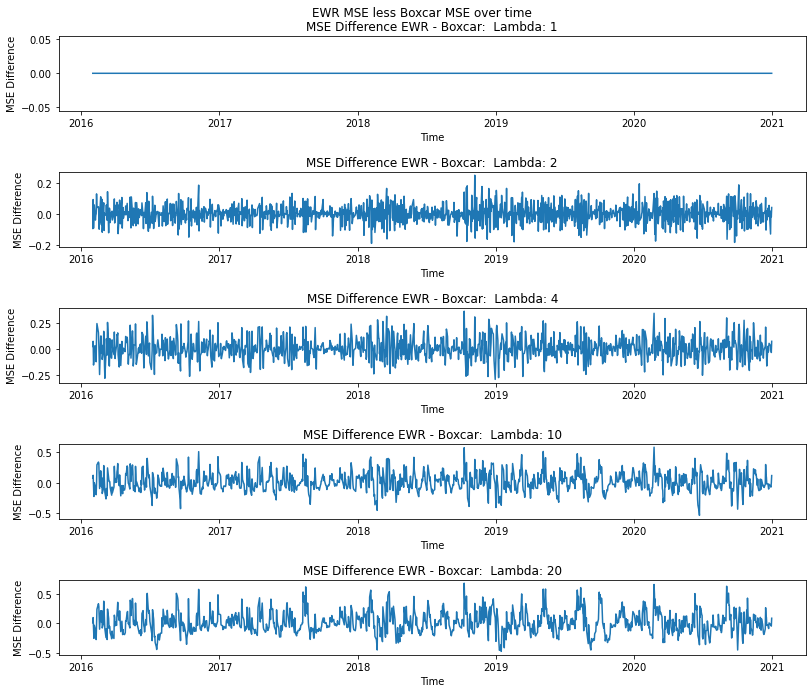

In [642]:
l_dict = {1:0, 
         2:1, 
         4: 2, 
          10: 3, 
          20:4
         }
fig, ax = plt.subplots(5, figsize = (12, 10))
fig.tight_layout(pad = 4.0)
for key, value in raw_errors_dict.items():
    r_type, l = key 
    if r_type == "Boxcar":
        cord = l_dict[l]
        to_plot = raw_errors_dict[('EWR', l)] - value
        ax[cord].plot(to_plot)
    
    
        ax[cord].set_xlabel('Time')
        ax[cord].set_ylabel('MSE Difference')
        ax[cord].set_title('MSE Difference EWR - Boxcar: ' + ' Lambda: '+ str(l))
    
fig.suptitle("EWR MSE less Boxcar MSE over time");

Here we see some very interesting results. We have that for lambda = 1, we have the exact same results, this makes sense because the EWR gives everything a weight of 1, so it would exactly match the OLS boxcar. Once we switch to lambda is 2 and 4, we see that periods where Boxcar does better is quickly accompanied by periods when EWR does better. For lambda = 10, we get that EWR and Boxcar do about the same, and for lambda is 20, we can't really tell which is doing better. We will then compare these to the VIX daily value to see if there is some correlation. 

Regression Slope for VIX vs. EWR minus Boxcar at  Lambda: 20
 is  3.812908078738717
Regression Slope for VIX vs. EWR minus Boxcar at  Lambda: 10
 is  4.056280958056735
Regression Slope for VIX vs. EWR minus Boxcar at  Lambda: 4
 is  3.1110059862166928
Regression Slope for VIX vs. EWR minus Boxcar at  Lambda: 2
 is  1.381669282102741


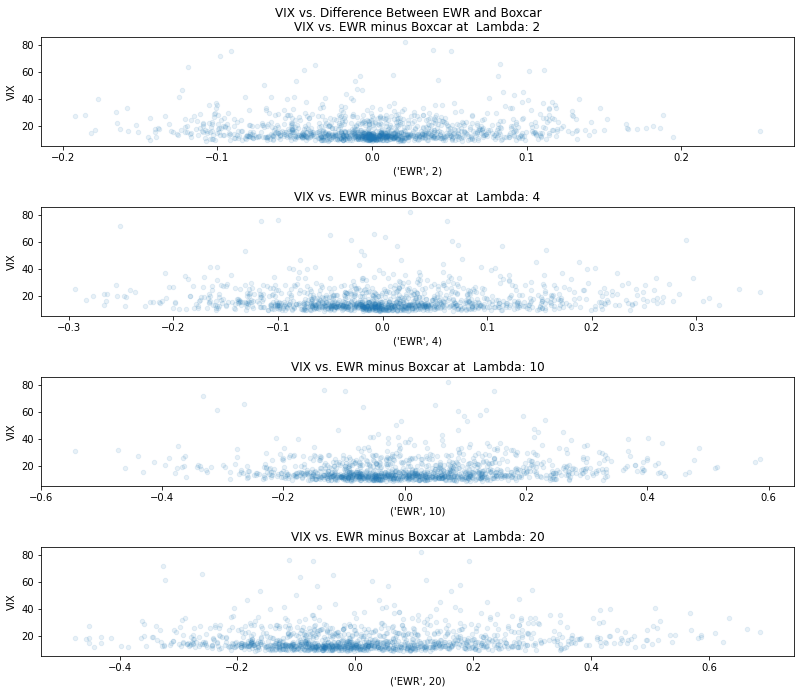

In [649]:
VIX = pd.read_csv('http://cache.quantconnect.com/alternative/cboe/vix.csv', header=1)
VIX.set_index('Date', inplace=True)
VIX = VIX.loc['02/01/2016':'12/31/2020']['VIX Close'];

l_dict = { 
         2:0, 
         4: 1, 
          10: 2, 
          20:3
         }


fig, ax = plt.subplots(4, figsize = (12, 10))
fig.tight_layout(pad = 4.0)
raw_errors_df = pd.DataFrame(raw_errors_dict)
raw_errors_df['VIX'] = VIX.values
for column in raw_errors_df:

    r_type, l = column  
    
    if l != 1 and l != '' and r_type =='EWR':
        x_cord = l_dict[l]
        
        raw_errors_df['to_plot'] = raw_errors_df[column] - raw_errors_df[('Boxcar', l)]
        raw_errors_df.plot(x = 'to_plot', y = 'VIX', kind = 'scatter', ax = ax[x_cord], alpha = 0.1)

    
        ax[x_cord].set_xlabel(column)
        ax[x_cord].set_ylabel('VIX')
        ax[x_cord].set_title('VIX vs. ' + 'EWR minus Boxcar at ' + ' Lambda: '+ str(l) )
        print('Regression Slope for '+ 'VIX vs. ' + 'EWR minus Boxcar at ' + ' Lambda: '+ str(l) +'\n'
             + ' is ', np.cov(raw_errors_df['to_plot'], raw_errors_df['VIX'])[0,1] / np.var(raw_errors_df['to_plot']))
        
    
fig.suptitle("VIX vs. Difference Between EWR and Boxcar \n");

In economic theory, both the Boxcar and the EWR would struggle to predict if there are large one off events which through them off. The EWR should be better at handling these cases than the Boxcar. If moments like this happen, we might expect to see spikes in the VIX. Therefore, we plotted the VIX against all of our regressions. 

In conclusion, we find that there is a positive regression slope in all four cases. As vol increases, we would have that the EWR's MSE is larger than the Boxcar's which is counterintuitive. Again, this is consistent with everything else we have found so far and can be attributed to a couple of things potentially. 

(i) We measured "correct" with a 5 day forward boxcar which is potentially more likely to look like the past boxcar than an EWR. 

(ii) There is an error somewhere above in the script which is giving us incorrect results. 

(iii) The weights given to the EWR are not optimal and for some reasons give the recent past too much or too little weight undoing the hypothetically predictive powers of the EWR over boxcar. 
 